In [14]:
from settings import Settings
import matplotlib.pyplot as plt

import os
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from utils.datasets import TrainDataset, TestDataset
from torchvision.transforms import *
from torch.autograd import Variable
from model import Net
from tensorboardX import SummaryWriter
from PIL import Image
import math
import numpy as np

In [15]:
settings = Settings()
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)
print(settings.dataset_info['SR_testing_datasets'])
print(settings.lr)

cuda
{'link': 'http://vllab.ucmerced.edu/wlai24/LapSRN/results/SR_testing_datasets.zip', 'id': 'Set5', 'is_gray': False, 'scale_factor': 3, 'path': './'}
0.1


In [16]:
def load_dataset(dataset='train'):
    if settings.num_channels == 1:
        is_gray = True
    else:
        is_gray = False

    if dataset == 'train':
        print('Loading train datasets...')
        train_set = TrainDataset(settings=settings)
        return DataLoader(dataset=train_set, num_workers=settings.num_threads, batch_size=settings.batch_size,
                          shuffle=True)
    elif dataset == 'test':
        print('Loading test datasets...')
        test_set = TestDataset(settings=settings)
        return DataLoader(dataset=test_set, num_workers=settings.num_threads, batch_size=settings.test_batch_size,
                          shuffle=False)
    elif dataset == 'gdata':
        print('github')
        train_set = DatasetFromHdf5('datasets/data/train.h5')
        return DataLoader(dataset=train_set, num_workers=settings.num_threads, batch_size=settings.test_batch_size,
                          shuffle=True)
        

In [17]:
def save_checkpoint(model, epoch):
    model_out_path = "checkpoint/" + "model_epoch_{}.pth".format(epoch)
    state = {"epoch": epoch ,"model": model}
    if not os.path.exists("checkpoint/"):
        os.makedirs("checkpoint/")

    torch.save(state, model_out_path)

    print("Checkpoint saved to {}".format(model_out_path))

In [18]:
def adjust_learning_rate(optimizer, epoch):
    """Sets the learning rate to the initial LR decayed by 10 every 100 epochs"""
    lr = settings.lr * (0.1 ** (epoch // 15))
    return lr

In [19]:
def img_interp(imgs, scale_factor, interpolation='bicubic'):
    if interpolation == 'bicubic':
        interpolation = Image.BICUBIC
    elif interpolation == 'bilinear':
        interpolation = Image.BILINEAR
    elif interpolation == 'nearest':
        interpolation = Image.NEAREST

    size = list(imgs.shape)

    if len(size) == 4:
        target_height = int(size[2] * scale_factor)
        target_width = int(size[3] * scale_factor)
        interp_imgs = torch.FloatTensor(size[0], size[1], target_height, target_width)
        for i, img in enumerate(imgs):
            transform = transforms.Compose([transforms.ToPILImage(),
                                            transforms.Scale((target_width, target_height), interpolation=interpolation),
                                            transforms.ToTensor()])

            interp_imgs[i, :, :, :] = transform(img)
        return interp_imgs
    else:
        target_height = int(size[1] * scale_factor)
        target_width = int(size[2] * scale_factor)
        transform = transforms.Compose([transforms.ToPILImage(),
                                        transforms.Scale((target_width, target_height), interpolation=interpolation),
                                        transforms.ToTensor()])
        return transform(imgs)

In [20]:
def train(training_data_loader, optimizer, model, criterion, epoch, writer, log_iter):
    lr = adjust_learning_rate(optimizer, epoch)
    for param_group in optimizer.param_groups:
        param_group["lr"] = lr
        
    print("Epoch = {}, lr = {}".format(epoch, optimizer.param_groups[0]["lr"]))
    avg_loss = 0.0
    for _ in range(100):
        for iteration, batch in enumerate(training_data_loader):
            input, target = Variable(batch[0]), Variable(batch[1], requires_grad=False)
            input = input.to(device)
            target = target.to(device)
            optimizer.zero_grad()
            loss = criterion(model(input), target)
            loss.backward() 

            nn.utils.clip_grad_norm_(model.parameters(), settings.clip) 
            optimizer.step()

            writer.add_scalar('loss/L2_loss', loss.item()/settings.batch_size, log_iter)
            writer.add_scalar('loss/PSNR', 10*math.log10(1/loss.item()),log_iter)
            #print(loss.item())
            avg_loss += loss.item()
            log_iter += 1
        
    return log_iter

In [21]:
train_data = load_dataset('train')
print(train_data)

Loading train datasets...
Successfully loaded.
/home/sunghwan19/VDSR-pytorch/datasets/291


In [18]:
model = Net().to(device)
writer = SummaryWriter()

optimizer = optim.SGD(model.parameters(), lr=settings.lr, momentum=0.9, weight_decay=0.0001)
criterion = nn.MSELoss()

total_epoch = 80
total_iter = 0

model.train()
for epoch in range(total_epoch):
    total_iter = train(train_data, optimizer, model, criterion, epoch, writer=writer, log_iter=total_iter)
    save_checkpoint(model, epoch)

Epoch = 0, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_0.pth
Epoch = 1, lr = 0.1


/home/sunghwan19/.local/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Net. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sunghwan19/.local/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv2d. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sunghwan19/.local/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Sequential. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "
/home/sunghwan19/.local/lib/python3.5/site-packages/torch/serialization.py:292: UserWarning: Couldn't retrieve source code for container of type Conv_Block. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + 

Checkpoint saved to checkpoint/model_epoch_1.pth
Epoch = 2, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_2.pth
Epoch = 3, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_3.pth
Epoch = 4, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_4.pth
Epoch = 5, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_5.pth
Epoch = 6, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_6.pth
Epoch = 7, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_7.pth
Epoch = 8, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_8.pth
Epoch = 9, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_9.pth
Epoch = 10, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_10.pth
Epoch = 11, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_11.pth
Epoch = 12, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_12.pth
Epoch = 13, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_13.pth
Epoch = 14, lr = 0.1
Checkpoint saved to checkpoint/model_epoch_14.pth
Epoch = 15, lr = 0.1
Checkpoint saved to che

In [10]:
checkpoint = torch.load('checkpoint/model_epoch_50.pth')
model = checkpoint['model']
test_dataset = load_dataset('test')
test_data = test_dataset.dataset.__getitem__(0)

Loading test datasets...
Successfully loaded.


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


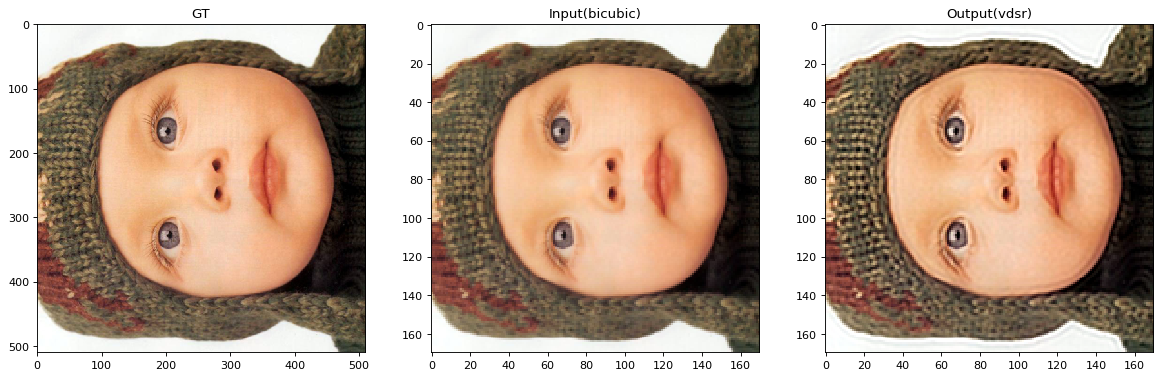

In [11]:
# Result visualization
fig = plt.figure(figsize=(18, 16), dpi= 80)
ax = plt.subplot("131")
ax.imshow(test_data[1].numpy().transpose((2, 1, 0)))
ax.set_title("GT")

ax = plt.subplot("132")
ax.imshow(test_data[0].numpy().transpose((2, 1, 0)))
ax.set_title("Input(bicubic)")

ax = plt.subplot("133")
ax.imshow(model(torch.Tensor(test_data[0].numpy()).unsqueeze(0).to(device)).cpu().detach().numpy().squeeze(0).transpose(2,1,0))
ax.set_title("Output(vdsr)")
plt.show()

In [12]:
# Here is the function for PSNR calculation
def PSNR(pred, gt, shave_border=0):
    height, width = pred.shape[:2]
    pred = pred[shave_border:height - shave_border, shave_border:width - shave_border]
    gt = gt[shave_border:height - shave_border, shave_border:width - shave_border]
    imdff = pred - gt
    rmse = math.sqrt(np.mean(imdff ** 2))
    if rmse == 0:
        return 100
    return 20 * math.log10(1 / rmse)

In [13]:
bef = test_data[0].numpy()
aft = model(torch.Tensor(test_data[0].numpy()).unsqueeze(0).to(device)).cpu().detach().numpy().squeeze(0)

PSNR(bef, aft)

29.380900426544994